In [1]:
import os
import json
from pyspark.sql import SparkSession
import pandas as pd
import polars as pl
from tqdm.auto import tqdm, trange
from concurrent.futures import ThreadPoolExecutor, as_completed
import matplotlib.pyplot as plt

SCRATCH = r"/scratch/IITB/ai-at-ieor/23m1521/datasets/Vaani"
DATADIR = r"/home/IITB/ai-at-ieor/23m1521/datasets/Vaani"
JSON_PATH = os.path.join(DATADIR, "Vaani_IIsc_Artpark_Full_Data.json")
# IMAGES_PATH = os.path.join(SCRATCH, "Images")
IMAGES_PARQUETS = os.path.join(SCRATCH, "images_parquets")
AUDIO_URLS = "audio_urls.txt"
IMAGES_URLS = "images_urls.txt"
IMAGE_ROOT_URL = 'https://vaani.iisc.ac.in/'
METADATA_PATH = r"/home/IITB/ai-at-ieor/23m1521/ashish/MTP/Vaani/Vaani-Images-Audio-MetaData.parquet"

In [2]:
df = pd.read_parquet(METADATA_PATH)

In [3]:
df

image_name        state  \
0        Images/IISc_VaaniProject_Aurangabad-SPECIFIC_0...  Maharashtra   
1        Images/IISc_VaaniProject_Aurangabad-SPECIFIC_0...  Maharashtra   
2        Images/IISc_VaaniProject_Aurangabad-SPECIFIC_0...  Maharashtra   
3                Images/IISc_VaaniProject_GENERIC_0073.jpg  Maharashtra   
4        Images/IISc_VaaniProject_Aurangabad-SPECIFIC_0...  Maharashtra   
...                                                    ...          ...   
9584927          Images/IISc_VaaniProject_GENERIC_0554.jpg    Karnataka   
9584928  Images/IISc_VaaniProject_Chamrajnagar-SPECIFIC...    Karnataka   
9584929  Images/IISc_VaaniProject_Chamrajnagar-SPECIFIC...    Karnataka   
9584930  Images/IISc_VaaniProject_Chamrajnagar-SPECIFIC...    Karnataka   
9584931  Images/IISc_VaaniProject_Chamrajnagar-SPECIFIC...    Karnataka   

               district  gender audio_language  \
0            Aurangabad  female        Marathi   
1            Aurangabad  female        Marathi   
2            Aurangabad  female        Marathi   
3            Aurangabad  female        Marathi   
4            Aurangabad  female        Marathi   
...                 ...     ...            ...   
9584927  Chamarajanagar  female        Kannada   
9584928  Chamarajanagar  female        Kannada   
9584929  Chamarajanagar  female        Kannada   
9584930  Chamarajanagar  female        Kannada   
9584931  Chamarajanagar  female        Kannada   

                                                audio_name  
0        Audios/Aurangabad/IISc_VaaniProject_S_Maharash...  
1        Audios/Aurangabad/IISc_VaaniProject_S_Maharash...  
2        Audios/Aurangabad/IISc_VaaniProject_S_Maharash...  
3        Audios/Aurangabad/IISc_VaaniProject_S_Maharash...  
4        Audios/Aurangabad/IISc_VaaniProject_S_Maharash...  
...                                                    ...  
9584927  Audios/Chamrajn/IISc_VaaniProject_M_KA_Chamraj...  
9584928  Audios/Chamrajn/IISc_VaaniProject_M_KA_Chamraj...  
9584929  Audios/Chamrajn/IISc_VaaniProject_M_KA_Chamraj...  
9584930  Audios/Chamrajn/IISc_VaaniProject_M_KA_Chamraj...  
9584931  Audios/Chamrajn/IISc_VaaniProject_M_KA_Chamraj...  

[9584932 rows x 6 columns]

In [4]:
print(df.audio_language.value_counts(normalize=False).to_dict())

{'Hindi': 4620343, 'Bengali': 951726, 'Kannada': 885901, 'Telugu': 863810, 'Marathi': 586031, 'English': 380943, 'Maithili': 225261, 'Chhattisgarhi': 220323, 'Bhojpuri': 167664, 'Rajasthani': 112791, 'Garhwali': 98456, 'Urdu': 93432, 'Angika': 50361, 'Magahi': 42221, 'Konkani': 38341, 'Thethi(Maithili)': 24818, 'Marwari': 23130, 'Khortha': 21857, 'Halbi': 21039, 'Surjapuri': 17392, 'Tulu': 16933, 'Bajjika': 11384, 'Sadri': 11018, 'Malvani': 8789, 'Ahirani': 8649, 'Surgujia': 8246, 'Khari Boli': 7190, 'Bihari': 6766, 'Kurukh': 6747, 'Tamil': 6513, 'Awadhi': 6114, 'Kumaoni': 4361, 'Ahirani/Khandeshi': 4297, 'hindi': 4285, 'Beary': 3981, 'Santali': 3063, 'Bundeli': 2397, 'Gondi': 2364, 'Bhili': 2136, 'Malto': 2046, 'Malayalam': 1389, 'Bhatri': 1127, 'Chattishgarhi': 1078, 'Dorli': 1062, 'Jaipuri': 1033, 'Chattisgarhi': 757, 'Surgujia ': 509, 'Duruwa': 470, 'Sanskrit': 402, 'Gujarati': 383, 'Nepalese': 355, 'Aassamese': 342, 'Sindhi': 328, 'Punjabi': 258, 'Oriya': 255, 'Odia': 216, 'Arunac

<Axes: xlabel='audio_language'>

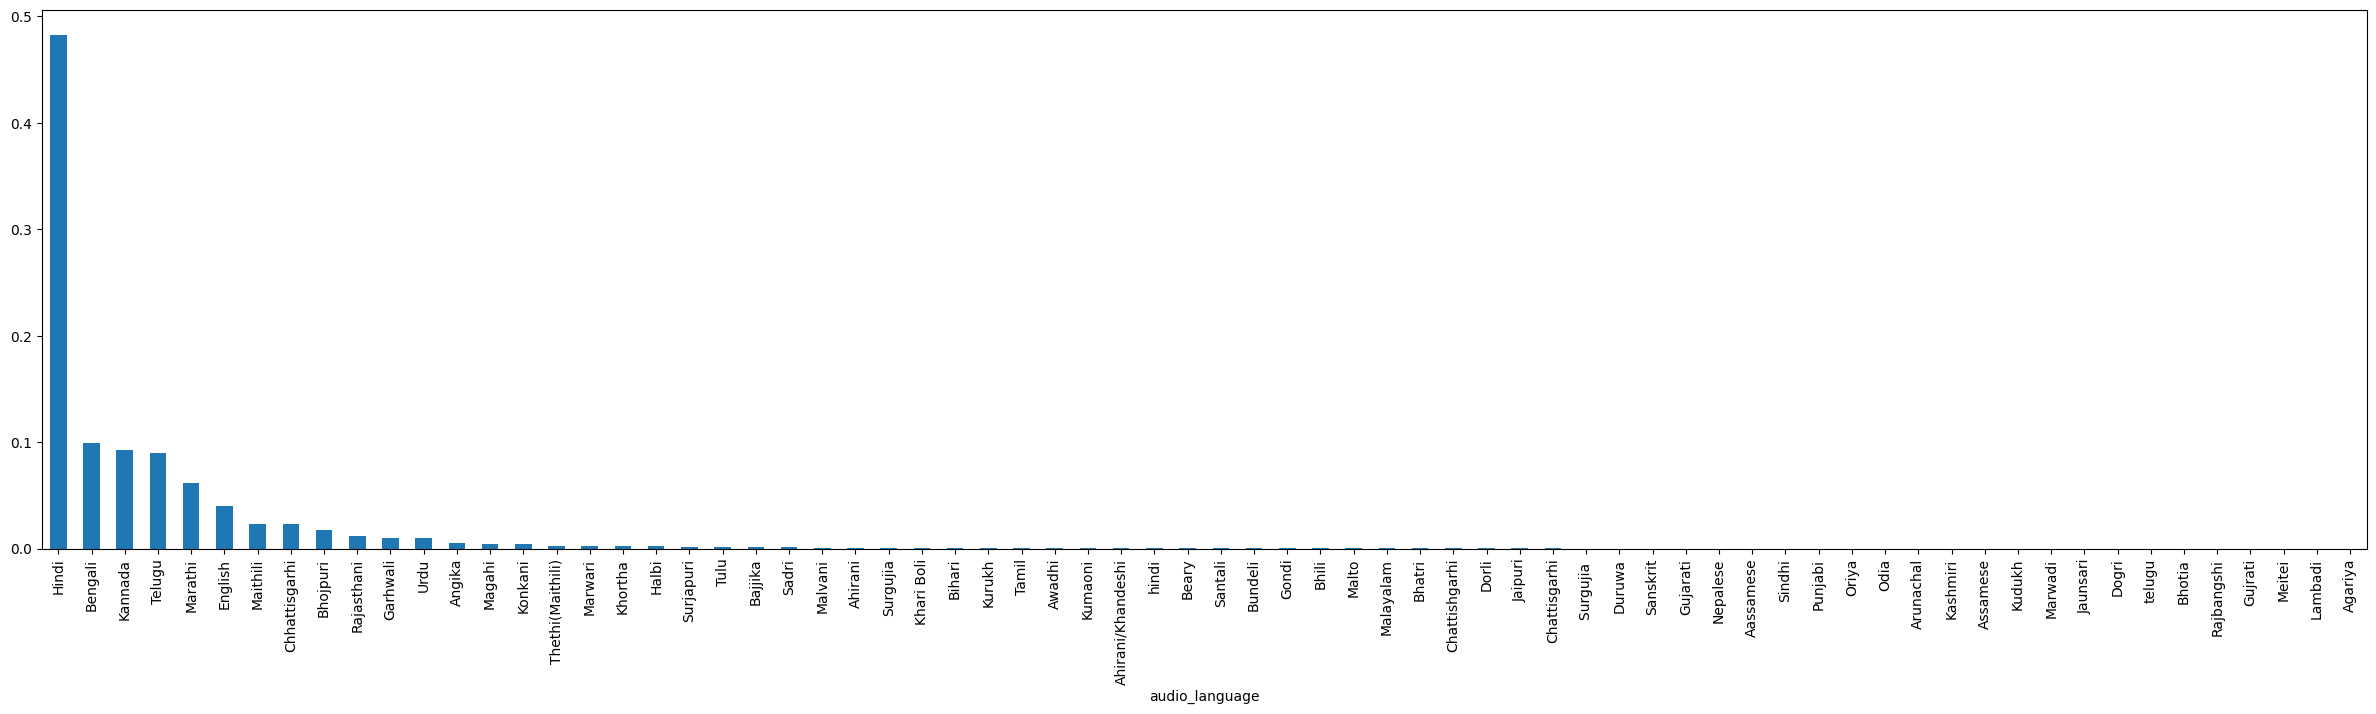

In [5]:
plt.figure(figsize=(30,7))
df.audio_language.value_counts(normalize=True).plot(kind='bar')

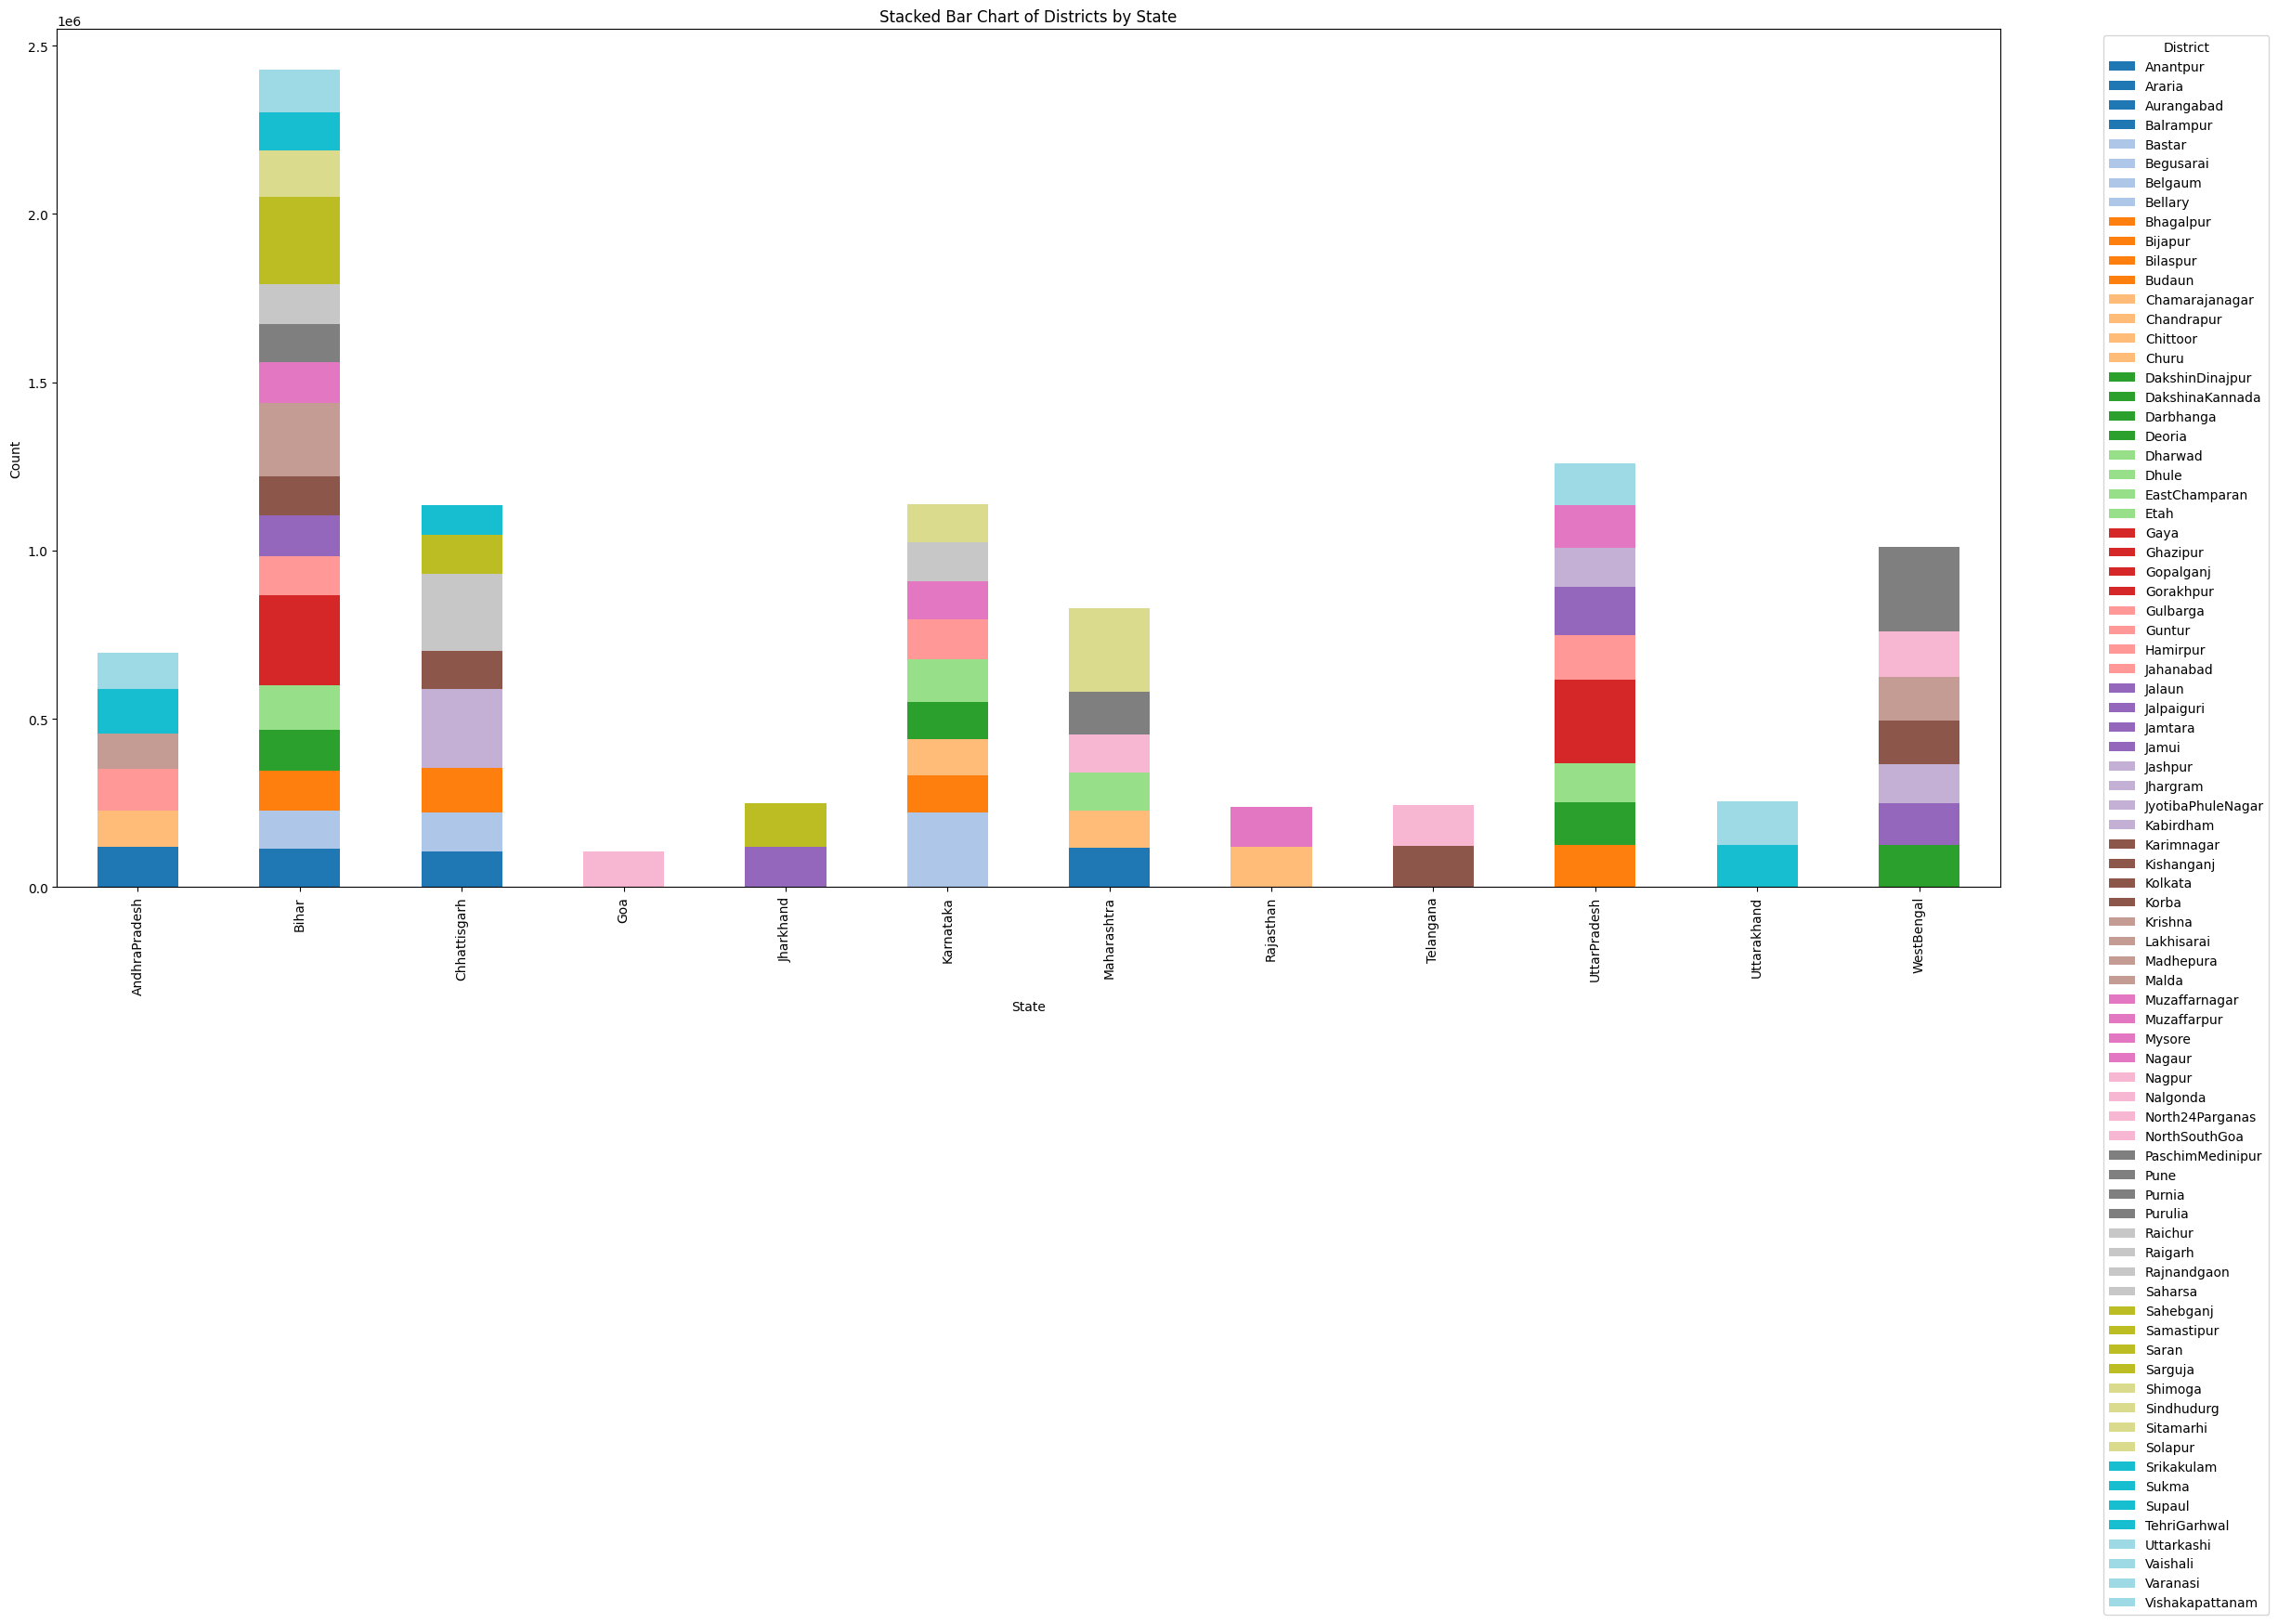

In [10]:
df_count = df.groupby(['state', 'district']).size().reset_index(name='count')
df_pivot = df_count.pivot(index='state', columns='district', values='count').fillna(0)
plt.figure(figsize=(27, 12))
df_pivot.plot(kind='bar', stacked=True, colormap='tab20', ax=plt.gca())

plt.ylabel('Count')
plt.xlabel('State')
plt.title('Stacked Bar Chart of Districts by State')
plt.legend(title='District', bbox_to_anchor=(1.05, 1), loc='upper left')
# plt.tight_layout()
plt.show()

In [11]:
df

image_name        state  \
0        Images/IISc_VaaniProject_Aurangabad-SPECIFIC_0...  Maharashtra   
1        Images/IISc_VaaniProject_Aurangabad-SPECIFIC_0...  Maharashtra   
2        Images/IISc_VaaniProject_Aurangabad-SPECIFIC_0...  Maharashtra   
3                Images/IISc_VaaniProject_GENERIC_0073.jpg  Maharashtra   
4        Images/IISc_VaaniProject_Aurangabad-SPECIFIC_0...  Maharashtra   
...                                                    ...          ...   
9584927          Images/IISc_VaaniProject_GENERIC_0554.jpg    Karnataka   
9584928  Images/IISc_VaaniProject_Chamrajnagar-SPECIFIC...    Karnataka   
9584929  Images/IISc_VaaniProject_Chamrajnagar-SPECIFIC...    Karnataka   
9584930  Images/IISc_VaaniProject_Chamrajnagar-SPECIFIC...    Karnataka   
9584931  Images/IISc_VaaniProject_Chamrajnagar-SPECIFIC...    Karnataka   

               district  gender audio_language  \
0            Aurangabad  female        Marathi   
1            Aurangabad  female        Marathi   
2            Aurangabad  female        Marathi   
3            Aurangabad  female        Marathi   
4            Aurangabad  female        Marathi   
...                 ...     ...            ...   
9584927  Chamarajanagar  female        Kannada   
9584928  Chamarajanagar  female        Kannada   
9584929  Chamarajanagar  female        Kannada   
9584930  Chamarajanagar  female        Kannada   
9584931  Chamarajanagar  female        Kannada   

                                                audio_name  
0        Audios/Aurangabad/IISc_VaaniProject_S_Maharash...  
1        Audios/Aurangabad/IISc_VaaniProject_S_Maharash...  
2        Audios/Aurangabad/IISc_VaaniProject_S_Maharash...  
3        Audios/Aurangabad/IISc_VaaniProject_S_Maharash...  
4        Audios/Aurangabad/IISc_VaaniProject_S_Maharash...  
...                                                    ...  
9584927  Audios/Chamrajn/IISc_VaaniProject_M_KA_Chamraj...  
9584928  Audios/Chamrajn/IISc_VaaniProject_M_KA_Chamraj...  
9584929  Audios/Chamrajn/IISc_VaaniProject_M_KA_Chamraj...  
9584930  Audios/Chamrajn/IISc_VaaniProject_M_KA_Chamraj...  
9584931  Audios/Chamrajn/IISc_VaaniProject_M_KA_Chamraj...  

[9584932 rows x 6 columns]

In [ ]:
df.image_name.unique().shape

(128807,)

In [32]:
df.groupby(['image_name']).size().reset_index(name='count')

image_name  count
0       Images/IISc_VaaniProject_Anantpur-SPECIFIC_000...     52
1       Images/IISc_VaaniProject_Anantpur-SPECIFIC_000...     41
2       Images/IISc_VaaniProject_Anantpur-SPECIFIC_000...     53
3       Images/IISc_VaaniProject_Anantpur-SPECIFIC_000...     38
4       Images/IISc_VaaniProject_Anantpur-SPECIFIC_000...     57
...                                                   ...    ...
128802  Images/IISc_VaaniProject_Vishakapattanam-SPECI...     35
128803  Images/IISc_VaaniProject_Vishakapattanam-SPECI...     19
128804  Images/IISc_VaaniProject_Vishakapattanam-SPECI...     17
128805  Images/IISc_VaaniProject_Vishakapattanam-SPECI...     31
128806  Images/IISc_VaaniProject_Vishakapattanam-SPECI...     36

[128807 rows x 2 columns]

In [2]:
import pandas as pd
image_dim_csv_path = r"/home/IITB/ai-at-ieor/23m1521/ashish/MTP/Vaani/image_dimensions_count.csv"

img_dim = pd.read_csv(image_dim_csv_path)
img_dim

Height  Width  Channels  Count
0        581   1032         3     93
1        732    720         3      1
2        900   1200         3  38475
3       1200    675         3   7161
4        675   1200         3  18243
...      ...    ...       ...    ...
4415    1023   1061         3      1
4416     480    936         3      1
4417    1063   1080         3      1
4418     828   1024         3      1
4419     480    767         3      1

[4420 rows x 4 columns]

In [3]:
img_dim.describe()

Height        Width  Channels         Count
count  4420.000000  4420.000000    4420.0   4420.000000
mean    816.225566   949.618778       3.0     29.141855
std     260.215789   204.559922       0.0    720.822915
min     203.000000   318.000000       3.0      1.000000
25%     586.000000   747.750000       3.0      1.000000
50%     780.000000   999.000000       3.0      1.000000
75%    1064.000000  1135.000000       3.0      4.000000
max    1200.000000  1200.000000       3.0  38475.000000